# Pushup Phase and Posture Classification

This notebook trains a model to classify:
- **Phase**: top, moving-down, bottom, moving-up, not-in-pushup
- **Posture**: good-form, hips-sagging, hips-high, partial-rom

Using IMU sensor data (accelerometer + gyroscope) from a single sensor.

---

**Running in Google Colab:**
1. Click "Runtime" → "Run all" or run cells one by one
2. When prompted, upload your `pushup_data_*.json` files
3. The model will train and show results

**GPU Acceleration:**
- Go to "Runtime" → "Change runtime type" → Select "T4 GPU" for faster training

## 1. Setup and Imports

In [76]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

# Install additional packages if needed
if IN_COLAB:
    !pip install -q seaborn

✓ Running in Google Colab


In [77]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("TensorFlow version:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.19.0
GPU available: True


## 2. Upload Data Files

Upload your `pushup_data_*.json` files from the data collector.

**In Colab:** A file upload dialog will appear below.  
**Locally:** Make sure files are in the `dataset/` folder.

In [78]:
if IN_COLAB:
    from google.colab import files

    print("📁 Please upload your pushup_data_*.json files...")
    uploaded = files.upload()

    # Create dataset directory
    os.makedirs('dataset', exist_ok=True)

    # Move uploaded files to dataset folder
    for filename in uploaded.keys():
        if filename.endswith('.json'):
            os.rename(filename, f'dataset/{filename}')
            print(f"✓ Saved: dataset/{filename}")

    print(f"\n✓ Upload complete! {len(uploaded)} file(s) ready.")
else:
    print("Running locally - make sure your JSON files are in the 'dataset/' folder")
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
        print("Created dataset/ folder")

📁 Please upload your pushup_data_*.json files...


Saving pushup_data_20251204_181709.json to pushup_data_20251204_181709.json
Saving pushup_data_20251204_181925.json to pushup_data_20251204_181925.json
Saving pushup_data_20251204_182051.json to pushup_data_20251204_182051.json
Saving pushup_data_20251204_182238.json to pushup_data_20251204_182238.json
Saving pushup_data_20251204_182326.json to pushup_data_20251204_182326.json
Saving pushup_data_20251204_183010.json to pushup_data_20251204_183010.json
Saving pushup_data_20251204_183217.json to pushup_data_20251204_183217.json
Saving pushup_data_20251204_183616.json to pushup_data_20251204_183616.json
Saving pushup_data_20251204_184328.json to pushup_data_20251204_184328.json
Saving pushup_data_20251204_184653.json to pushup_data_20251204_184653.json
Saving pushup_data_20251204_184918.json to pushup_data_20251204_184918.json
Saving pushup_data_20251204_185236.json to pushup_data_20251204_185236.json
Saving pushup_data_20251204_185644.json to pushup_data_20251204_185644.json
Saving pushu

## 3. Load Data

Load all JSON files from the dataset folder.

In [79]:
# Path to dataset folder
dataset_path = Path("dataset")

# Load all JSON files
all_sessions = []

json_files = list(dataset_path.glob("*.json"))
if len(json_files) == 0:
    raise FileNotFoundError("❌ No JSON files found in dataset/ folder. Please upload your data files.")

for json_file in json_files:
    print(f"Loading {json_file.name}...")
    with open(json_file, 'r') as f:
        data = json.load(f)
        all_sessions.extend(data['sessions'])

print(f"\n✓ Total sessions loaded: {len(all_sessions)}")
print(f"✓ Total samples: {sum(s['sample_count'] for s in all_sessions)}")

Loading pushup_data_20251204_190149.json...
Loading pushup_data_20251204_182238.json...
Loading pushup_data_20251204_183010.json...
Loading pushup_data_20251204_183217.json...
Loading pushup_data_20251204_185236.json...
Loading pushup_data_20251204_182051.json...
Loading pushup_data_20251204_182326.json...
Loading pushup_data_20251204_181925.json...
Loading pushup_data_20251204_185644.json...
Loading pushup_data_20251204_184918.json...
Loading pushup_data_20251204_184328.json...
Loading pushup_data_20251204_183616.json...
Loading pushup_data_20251204_191217.json...
Loading pushup_data_20251204_184653.json...
Loading pushup_data_20251204_181709.json...
Loading pushup_data_20251204_190654.json...

✓ Total sessions loaded: 277
✓ Total samples: 22880


## 4. Explore the Data

In [80]:
# Check label distribution
phase_labels = [s['phase_label'] for s in all_sessions]
posture_labels = [s['posture_label'] for s in all_sessions]

print("Phase label distribution:")
for label, count in Counter(phase_labels).items():
    print(f"  {label}: {count}")

print("\nPosture label distribution:")
for label, count in Counter(posture_labels).items():
    print(f"  {label}: {count}")

# Sample session info
print("\nSample session:")
sample = all_sessions[0]
print(f"  Phase: {sample['phase_label']}")
print(f"  Posture: {sample['posture_label']}")
print(f"  Duration: {sample['duration_sec']:.2f}s")
print(f"  Sample count: {sample['sample_count']}")
print(f"  Sample rate: {sample['sample_rate_hz']} Hz")
print(f"  IMU placement: {sample['imu_placement']}")

Phase label distribution:
  top: 277

Posture label distribution:
  hips-sagging: 40
  good-form: 155
  hips-high: 41
  partial-rom: 41

Sample session:
  Phase: top
  Posture: hips-sagging
  Duration: 2.04s
  Sample count: 81
  Sample rate: 40 Hz
  IMU placement: Sternum


In [ ]:
# Visualize a sample session
sample_session = all_sessions[0]
data_points = sample_session['data']

# Calculate time from sample index (40 Hz sample rate)
# This is more reliable than elapsed_sec which may be calculated incorrectly
timestamps = [i / 40.0 for i in range(len(data_points))]
ax_vals = [d['ax'] for d in data_points]
ay_vals = [d['ay'] for d in data_points]
az_vals = [d['az'] for d in data_points]
gx_vals = [d['gx'] for d in data_points]
gy_vals = [d['gy'] for d in data_points]
gz_vals = [d['gz'] for d in data_points]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.plot(timestamps, ax_vals, label='ax', alpha=0.8)
ax1.plot(timestamps, ay_vals, label='ay', alpha=0.8)
ax1.plot(timestamps, az_vals, label='az', alpha=0.8)
ax1.set_ylabel('Acceleration (g)')
ax1.set_title(f"Sample Session - Phase: {sample_session['phase_label']}, Posture: {sample_session['posture_label']}")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(timestamps, gx_vals, label='gx', alpha=0.8)
ax2.plot(timestamps, gy_vals, label='gy', alpha=0.8)
ax2.plot(timestamps, gz_vals, label='gz', alpha=0.8)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angular Velocity (°/s)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(len(all_sessions))

## 5. Create Sliding Windows

Convert sessions into fixed-length windows for training.

In [82]:
# Window parameters
WINDOW_SIZE = 50  # Number of samples per window (50 samples @ 40Hz = 1.25 seconds)
STRIDE = 10       # Stride for sliding window (10 samples = 0.25 seconds)

def create_windows(session, window_size=WINDOW_SIZE, stride=STRIDE):
    """
    Create sliding windows from a session.
    Returns: list of (window_data, phase_label, posture_label) tuples
    """
    data_points = session['data']

    # Extract IMU values as numpy array
    imu_data = np.array([[d['ax'], d['ay'], d['az'],
                          d['gx'], d['gy'], d['gz']]
                         for d in data_points])

    # Create sliding windows
    windows = []
    for i in range(0, len(imu_data) - window_size + 1, stride):
        window = imu_data[i:i+window_size]
        windows.append((
            window,
            session['posture_label']
        ))

    return windows

# Create windows from all sessions
all_windows = []
for session in all_sessions:
    windows = create_windows(session)
    all_windows.extend(windows)

print(f"✓ Total windows created: {len(all_windows)}")
print(f"✓ Window shape: {all_windows[0][0].shape}")
print(f"✓ First window - Posture: {all_windows[0][1]}")

✓ Total windows created: 1058
✓ Window shape: (50, 6)
✓ First window - Posture: hips-sagging


## 6. Prepare Training Data

In [83]:
# Separate features and labels
X = np.array([w[0] for w in all_windows])  # Shape: (num_windows, 50, 6)
y_posture = np.array([w[1] for w in all_windows])

print("X shape:", X.shape)
print("y_posture shape:", y_posture.shape)

# Encode labels
posture_encoder = LabelEncoder()

y_posture_encoded = posture_encoder.fit_transform(y_posture)

print("\nPosture classes:", posture_encoder.classes_)

# Normalize the IMU data
# Compute mean and std for each channel
mean = X.mean(axis=(0, 1))
std = X.std(axis=(0, 1))

print("\nMean per channel:", mean)
print("Std per channel:", std)

X_normalized = (X - mean) / (std + 1e-8)

# Split into train/validation/test
X_train, X_temp, y_posture_train, y_posture_temp = train_test_split(
    X_normalized, y_posture_encoded, test_size=0.3, random_state=42, stratify=y_posture_encoded
)

X_val, X_test, y_posture_val, y_posture_test = train_test_split(
    X_temp, y_posture_temp, test_size=0.5, random_state=42, stratify=y_posture_temp
)

print("\nTrain set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

X shape: (1058, 50, 6)
y_posture shape: (1058,)

Posture classes: ['good-form' 'hips-high' 'hips-sagging' 'partial-rom']

Mean per channel: [ 0.21002982 -0.0125976   0.96834566  0.1763402   1.13920085  0.94968138]
Std per channel: [ 0.27886892  0.11287905  0.28730744 13.64203132 36.71071629  6.24481333]

Train set: (740, 50, 6)
Validation set: (159, 50, 6)
Test set: (159, 50, 6)


## 7. Build Model

In [84]:
def build_model(input_shape, num_posture_classes):
    """
    Build a CNN model for posture classification using Conv1D and GlobalAveragePooling1D.
    """
    inputs = keras.Input(shape=input_shape, name='imu_input')

    # Shared feature extraction layers
    x = layers.Conv1D(32, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # TFLite-friendly replacement for LSTMs
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x) # Global Average Pooling to flatten for Dense layers
    x = layers.Dropout(0.3)(x)

    # Posture classification head
    posture_dense = layers.Dense(32, activation='relu', name='posture_dense')(x)
    posture_output = layers.Dense(num_posture_classes, activation='softmax', name='posture_output')(posture_dense)

    model = keras.Model(inputs=inputs, outputs=posture_output)

    return model

model = build_model(
        input_shape=(WINDOW_SIZE, 6),
        num_posture_classes=len(posture_encoder.classes_)
)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ imu_input (InputLayer)          │ (None, 50, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 50, 32)         │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 25, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ posture_dense (Dense)           │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ posture_output (Dense)          │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,156 (160.77 KB)

 Trainable params: 40,708 (159.02 KB)

 Non-trainable params: 448 (1.75 KB)

In [85]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'posture_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'posture_output': ['accuracy']
    }
)

## 8. Train the Model

In [86]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Train
history = model.fit(
    X_train,
    y_posture_train,
    validation_data=(
        X_val,
        y_posture_val
    ),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.6307 - loss: 0.9577 - val_accuracy: 0.8931 - val_loss: 0.7856 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9569 - loss: 0.1654 - val_accuracy: 0.9497 - val_loss: 0.5061 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9714 - loss: 0.0965 - val_accuracy: 0.9811 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9893 - loss: 0.0551 - val_accuracy: 1.0000 - val_loss: 0.2510 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9866 - loss: 0.0454 - val_accuracy: 1.0000 - val_loss: 0.1581 - learning_rate: 0.0010
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9830 - loss: 0.0566 - val_accuracy: 1.0000 - val_loss: 0.1193 - learning_rate: 0.0010
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9934 - loss: 0.0397 - val_accurac

## 9. Evaluate the Model

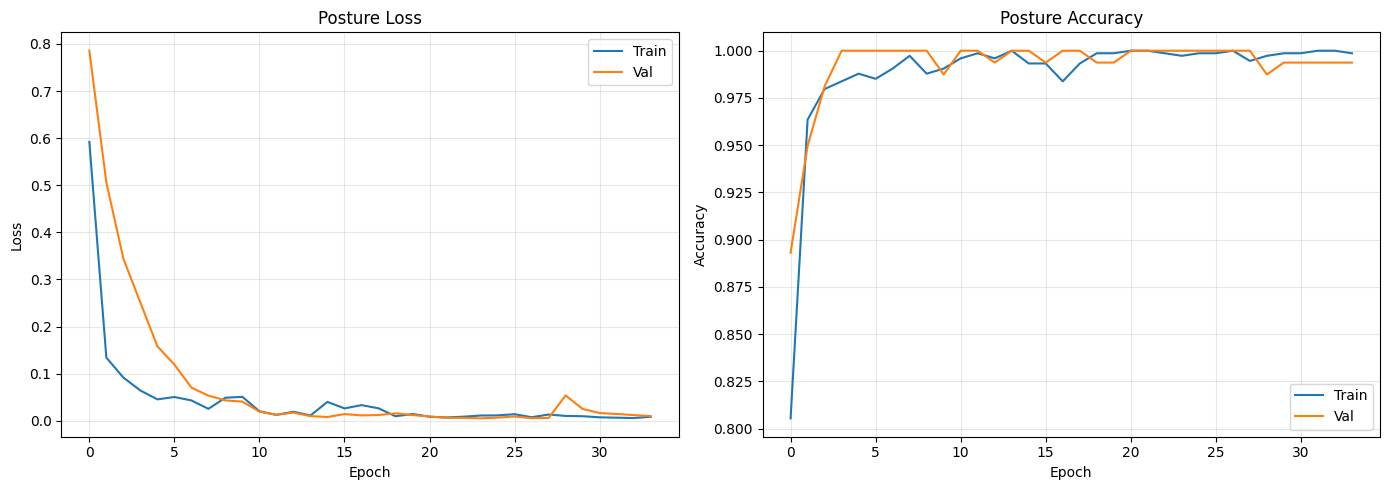

In [87]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Posture loss
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Val')
axes[0].set_title('Posture Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Posture accuracy
axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Val')
axes[1].set_title('Posture Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [88]:
# Evaluate on test set
test_results = model.evaluate(
    X_test,
    y_posture_test,
    verbose=0
)

print("Test Results:")
print(f"  Posture Loss: {test_results[0]:.4f}")
print(f"  Posture Accuracy: {test_results[1]:.4f}")

Test Results:
  Posture Loss: 0.0023
  Posture Accuracy: 1.0000


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


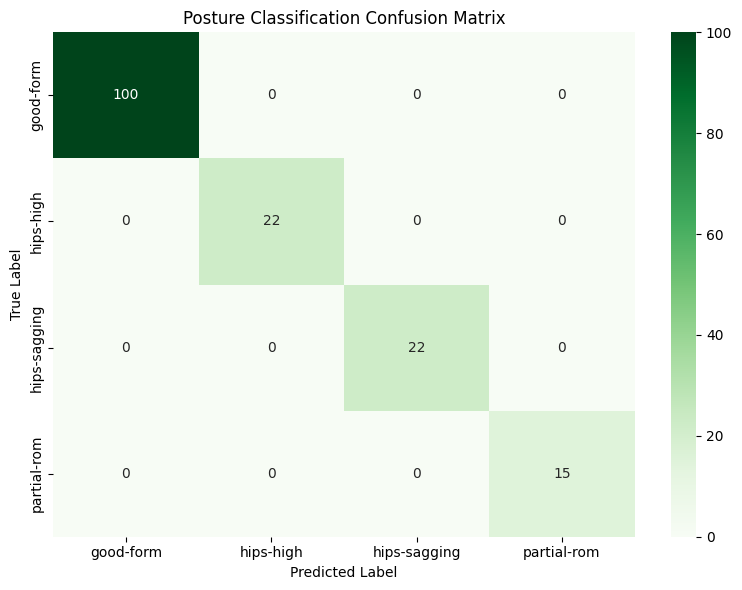

Posture Classification Report:
              precision    recall  f1-score   support

   good-form       1.00      1.00      1.00       100
   hips-high       1.00      1.00      1.00        22
hips-sagging       1.00      1.00      1.00        22
 partial-rom       1.00      1.00      1.00        15

    accuracy                           1.00       159
   macro avg       1.00      1.00      1.00       159
weighted avg       1.00      1.00      1.00       159



In [89]:
# Posture confusion matrix
posture_pred = model.predict(X_test)
posture_pred_classes = np.argmax(posture_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

posture_cm = confusion_matrix(y_posture_test, posture_pred_classes)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(posture_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=posture_encoder.classes_,
            yticklabels=posture_encoder.classes_)
plt.title('Posture Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Posture Classification Report:")
print(classification_report(y_posture_test, posture_pred_classes,
                           target_names=posture_encoder.classes_))

## 10. Save the Model

In [90]:
# Save model
model.save('pushup_model.h5')
print("✓ Model saved to pushup_model.h5")

# Save label encoders and normalization parameters
metadata = {
    'posture_classes': posture_encoder.classes_.tolist(),
    'mean': mean.tolist(),
    'std': std.tolist(),
    'window_size': WINDOW_SIZE,
    'stride': STRIDE,
    'sample_rate_hz': 40
}

with open('pushup_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Metadata saved to pushup_model_metadata.json")

✓ Model saved to pushup_model.h5
✓ Metadata saved to pushup_model_metadata.json


## 11. Test on Sample Data

In [91]:
# Test prediction on a random sample
sample_idx = np.random.randint(0, len(X_test))
sample_window = X_test[sample_idx:sample_idx+1]

posture_prob = model.predict(sample_window, verbose=0)

predicted_posture = posture_encoder.classes_[np.argmax(posture_prob)]
true_posture = posture_encoder.classes_[y_posture_test[sample_idx]]

print("Sample Prediction:")
print(f"  True Posture: {true_posture} → Predicted: {predicted_posture}")
print(f"\nPosture probabilities:")
for i, cls in enumerate(posture_encoder.classes_):
    print(f"  {cls}: {posture_prob[0][i]:.3f}")

Sample Prediction:
  True Posture: good-form → Predicted: good-form

Posture probabilities:
  good-form: 1.000
  hips-high: 0.000
  hips-sagging: 0.000
  partial-rom: 0.000


### 12.1 Convert to Float32 TFLite Model

First, convert to a standard float32 TFLite model (no quantization).

In [92]:
# Save model in SavedModel format (required for TFLite conversion)
SAVED_MODEL_DIR = 'saved_model'
model.export(SAVED_MODEL_DIR, save_format='tf')
print(f"✓ Saved model to {SAVED_MODEL_DIR}/")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 6), dtype=tf.float32, name='imu_input')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136185065939472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065939664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065938320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065939280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065940816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065940048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065940432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065940240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065936976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065941584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136185065941200: TensorSpec(

In [93]:
# Install xxd tool for converting .tflite to .cc
if IN_COLAB:
    !apt-get update && apt-get -qq install xxd
    print("✓ Installed xxd tool")
else:
    print("Make sure xxd is installed (usually comes with vim)")

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✓ Installed xx

### 12.2 Convert to Quantized INT8 TFLite Model

Now convert to an INT8 quantized model for embedded deployment. This reduces model size significantly.

In [94]:
# Convert to TFLite (float32, no quantization)
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
tflite_model_float = converter.convert()

# Save float model
FLOAT_MODEL_FILE = 'pushup_model_float.tflite'
with open(FLOAT_MODEL_FILE, 'wb') as f:
    f.write(tflite_model_float)

print(f"✓ Float32 TFLite model saved to {FLOAT_MODEL_FILE}")
print(f"  Size: {len(tflite_model_float):,} bytes ({len(tflite_model_float)/1024:.2f} KB)")

✓ Float32 TFLite model saved to pushup_model_float.tflite
  Size: 173,648 bytes (169.58 KB)


### 12.3 Compare Model Sizes

In [95]:
# Prepare representative dataset for quantization
def representative_dataset():
    """
    Provide sample data for quantization calibration.
    Uses a subset of training data.
    """
    for i in range(min(100, len(X_train))):
        # TFLite expects batch dimension
        yield [X_train[i:i+1].astype(np.float32)]

# Convert to quantized TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)

# Enable quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# Ensure full integer quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert
tflite_model_quantized = converter.convert()

# Save quantized model
QUANTIZED_MODEL_FILE = 'pushup_model_quantized.tflite'
with open(QUANTIZED_MODEL_FILE, 'wb') as f:
    f.write(tflite_model_quantized)

print(f"✓ Quantized INT8 TFLite model saved to {QUANTIZED_MODEL_FILE}")
print(f"  Size: {len(tflite_model_quantized):,} bytes ({len(tflite_model_quantized)/1024:.2f} KB)")

✓ Quantized INT8 TFLite model saved to pushup_model_quantized.tflite
  Size: 59,768 bytes (58.37 KB)


In [96]:
# Compare model sizes
import pandas as pd

h5_size = os.path.getsize('pushup_model.h5')
float_size = len(tflite_model_float)
quantized_size = len(tflite_model_quantized)

size_comparison = pd.DataFrame([
    ['Keras .h5', h5_size, f"{h5_size/1024:.2f} KB", '100%'],
    ['TFLite Float32', float_size, f"{float_size/1024:.2f} KB", f"{float_size/h5_size*100:.1f}%"],
    ['TFLite INT8 Quantized', quantized_size, f"{quantized_size/1024:.2f} KB", f"{quantized_size/h5_size*100:.1f}%"]
], columns=['Model Type', 'Bytes', 'Size', '% of Original'])

print("Model Size Comparison:")
print(size_comparison.to_string(index=False))

print(f"\n✓ Compression:")
print(f"  Float32 model: {h5_size - float_size:,} bytes saved")
print(f"  Quantized model: {h5_size - quantized_size:,} bytes saved ({(1 - quantized_size/h5_size)*100:.1f}% reduction)")

Model Size Comparison:
           Model Type  Bytes      Size % of Original
            Keras .h5 560512 547.38 KB          100%
       TFLite Float32 173648 169.58 KB         31.0%
TFLite INT8 Quantized  59768  58.37 KB         10.7%

✓ Compression:
  Float32 model: 386,864 bytes saved
  Quantized model: 500,744 bytes saved (89.3% reduction)


## 13. Test TFLite Model Accuracy

Test both float32 and quantized INT8 models on the test set to measure accuracy impact.

In [97]:
def test_tflite_model(tflite_model_content, X_test, y_posture_test, model_name="TFLite"):
    """
    Test a TFLite model on the test set and return accuracy.
    """
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_content=tflite_model_content)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()[0]
    posture_output_details = interpreter.get_output_details()[0]

    # Check if model is quantized
    input_scale, input_zero_point = input_details['quantization']
    is_quantized = input_scale > 0  # If scale > 0, model uses quantization

    posture_correct = 0
    total = len(X_test)

    for i in range(total):
        sample = X_test[i:i+1].astype(np.float32)

        # Quantize input if needed
        if is_quantized:
            sample = sample / input_scale + input_zero_point
            sample = sample.astype(np.int8)

        # Run inference
        interpreter.set_tensor(input_details['index'], sample)
        interpreter.invoke()

        # Get outputs
        posture_output = interpreter.get_tensor(posture_output_details['index'])[0]

        # Dequantize outputs if needed
        if is_quantized:
            posture_scale, posture_zero_point = posture_output_details['quantization']

            posture_output = (posture_output.astype(np.float32) - posture_zero_point) * posture_scale

        # Get predictions
        posture_pred = np.argmax(posture_output)

        # Check correctness
        if posture_pred == y_posture_test[i]:
            posture_correct += 1

    posture_accuracy = posture_correct / total

    print(f"{model_name} Results:")
    print(f"  Posture Accuracy: {posture_accuracy:.4f} ({posture_correct}/{total})")
    print(f"  Quantized: {is_quantized}")

    return posture_accuracy

In [98]:
# Test Float32 model
print("Testing Float32 TFLite model...")
float_posture_acc = test_tflite_model(
    tflite_model_float, X_test, y_posture_test, "Float32"
)

print()

# Test Quantized model
print("Testing Quantized INT8 TFLite model...")
quant_posture_acc = test_tflite_model(
    tflite_model_quantized, X_test, y_posture_test, "Quantized INT8"
)

# Compare accuracies
print(f"\n✓ Accuracy Comparison:")
print(f"  Posture - Float32: {float_posture_acc:.4f} | Quantized: {quant_posture_acc:.4f} | Diff: {float_posture_acc - quant_posture_acc:+.4f}")

Testing Float32 TFLite model...
Float32 Results:
  Posture Accuracy: 1.0000 (159/159)
  Quantized: False

Testing Quantized INT8 TFLite model...
Quantized INT8 Results:
  Posture Accuracy: 1.0000 (159/159)
  Quantized: True

✓ Accuracy Comparison:
  Posture - Float32: 1.0000 | Quantized: 1.0000 | Diff: +0.0000


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## 14. Convert to C Array (.cc file)

Convert the quantized TFLite model to a C array for embedding in Arduino/ESP32 firmware.

In [99]:
# Convert quantized model to C header file using xxd
CC_MODEL_FILE = 'pushup_model.cc'

# Use Python to run the command with proper variable substitution
import subprocess
result = subprocess.run(
    ['xxd', '-i', QUANTIZED_MODEL_FILE],
    capture_output=True,
    text=True
)

# Write output to .cc file
with open(CC_MODEL_FILE, 'w') as f:
    f.write(result.stdout)

print(f"✓ Converted {QUANTIZED_MODEL_FILE} to {CC_MODEL_FILE}")
print(f"  Model can now be embedded in Arduino/ESP32 firmware")

# Show first few lines of the .cc file
print(f"\nFirst 10 lines of {CC_MODEL_FILE}:")
with open(CC_MODEL_FILE, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[:10]):
        print(line.rstrip())

✓ Converted pushup_model_quantized.tflite to pushup_model.cc
  Model can now be embedded in Arduino/ESP32 firmware

First 10 lines of pushup_model.cc:
unsigned char pushup_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0x08, 0x01, 0x00, 0x00, 0x54, 0xa6, 0x00, 0x00,
  0x64, 0xa6, 0x00, 0x00, 0x70, 0xe8, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x1e, 0x55, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,


## 15. Download All Model Files

Download all model files to your computer.

In [100]:
if IN_COLAB:
    from google.colab import files

    print("📥 Downloading trained model and metadata...")
    files.download('pushup_model.h5')
    files.download('pushup_model_metadata.json')
    print("✓ Download complete!")
else:
    print("Model saved locally as pushup_model.h5 and pushup_model_metadata.json")

📥 Downloading trained model and metadata...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download complete!
